# Corporate Credit Rating with Synthetic Data Based on the Altman Z-Score Model

>**<span style="color:RED">Important</span>**: 
>This solution is for demonstrative purposes only. It is not financial advice and should not be relied on as financial or investment advice. The associated notebooks, including the trained model, use synthetic data and are not intended for production.

This notebook walks you through how to create, train, and deploy a machine learning model. The model provides real-time credit rating predictions based on fictional company names and data.

<!-- Darren, I removed "real" before "data". If the company names are fictional, shouldn't the data also be fictional? (Didn't I see some real company names in the practice lab?) -->

### What is Altman's Z-Score?

The [Altman's Z-Score](https://www.creditguru.com/index.php/bankruptcy-and-insolvency/altman-z-score-insolvency-predictor) uses management discussion and analysis (**MD&A**) text data from SEC 10-K/Q filings, [SIC code](https://www.sec.gov/corpfin/division-of-corporation-finance-standard-industrial-classification-sic-code-list) (**industry_code**), and **eight financial variables** from a company's financial statement, such as balance sheet tables and income statements. The eight financial variables are: 

1. Current assets
2. Current liabilities
3. Total liabilities
4. EBIT (earnings before interest and tax)
5. Total assets
6. Net sales
7. Retained earnings
8. Market value of equity

The true label is the **Rating** column. 

The following snapshot shows an example of the input data:

![Input data](https://sagemaker-solutions-prod-us-east-2.s3.us-east-2.amazonaws.com/sagemaker-corporate-credit-rating/0.0.1/docs/input_data.png)

These eight financial variables translate into the five financial ratios used for the Altman Z-Score:  

* A: EBIT / total assets 
* B: Net sales / total assets
* C: Market value of equity / total liabilities
* D: Working capital / total assets
* E: Retained earnings / total assets

>**Reference**:
>1. Balance sheet data: https://fred.stlouisfed.org/release/tables?rid=434&eid=196197
>2. Income statement data: https://fred.stlouisfed.org/release/tables?rid=434&eid=195208
>3. Price to book: http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/pbvdata.html

#### Code cell 1

The following code cell sets several needed constants for the remaining cells of the notebook.

<span style="color:red"> You will need to replace the BUCKET value with the name of your Amazon SageMaker data bucket. </span> 

In [1]:
ROLE = "sagemaker_session_role"
REGION = "us-east-1"
SOLUTION_NAME = "credit-score-automation"
SOLUTION_PREFIX = 'sagemaker-cq-lab'
BUCKET = "sagemaker-lab-bucket-876113002723-53757e90" #Replace with the bucket name that you copied earlier.


#### Code cell 2

We have feature columns for the **MD&A** section in the 10K/Q SEC filings, **industry_code**, and **eight financial variables**. The label column is **Rating**. The following code cell reads this information into a Pandas DataFrame, and the head method prints out the first five rows.

<!-- I changed "8 corporate financial properties" to match the previous references. I suggest consistency, if possible, whichever term we choose. -->

In [2]:
import pandas as pd

df = pd.read_csv('CCR_data.csv')
print(df.shape)
df.head()

(3286, 11)


,MDNA,industry_code,TotalAssets,CurrentLiabs,TotalLiabs,RetainedEarnings,CurrentAssets,NetSales,EBIT,MktValueEquity,Rating
0,Management's Discussion and Analysis of Finan...,D,100.0,17.799125,54.751930,31.967575,27.200873,15.510656,1.250236,228.037340,AAA
1,Management's Discussion and Analysis of Finan...,D,100.0,17.357136,55.031821,32.138822,26.594829,14.047134,1.191216,229.468644,AAA
2,Management's Discussion and Analysis of Finan...,D,100.0,20.127360,53.173717,30.823923,26.356042,13.812715,1.475246,223.145011,AAA
3,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,I,100.0,21.430382,50.660280,32.623353,24.251476,14.122134,1.361792,231.070913,AAA
4,Management's Discussion and Analysis of Finan...,D,100.0,16.561499,50.324380,30.886953,29.116718,13.036245,1.325536,217.488716,AAA


#### Code cell 3

Next, we convert the eight financial variables into the five financial ratios. We add the five ratios to the dataset, drop the eight financial variables, and use the processed dataset for machine learning. The true label (**Rating**) is multicategorical, but it can be simplified into a binary fashion by grouping the ratings into two investment groups: a group above the investment grade (AAA, AA, A, BBB) and a group below the investment grade.

After the data preprocessing has completed, we have five numerical columns (**A, B, C, D, E**), one categorical column (**industry_code**), and a long-text column (**MD&A**).

<!-- I changed "MDNA" to "MD&A", which I also did earlier. -->

In [3]:
df["A"] = df["EBIT"]/df["TotalAssets"]
df["B"] = df["NetSales"]/df["TotalAssets"]
df["C"] = df["MktValueEquity"]/df["TotalLiabs"]
df["D"] = (df["CurrentAssets"]-df["CurrentLiabs"])/df["TotalAssets"]
df["E"] = df["RetainedEarnings"]/df["TotalAssets"]
df = df.drop(["TotalAssets","CurrentLiabs","TotalLiabs", "RetainedEarnings", "CurrentAssets", 
              "NetSales", "EBIT", "MktValueEquity"], axis=1)
df.head()

,MDNA,industry_code,Rating,A,B,C,D,E
0,Management's Discussion and Analysis of Finan...,D,AAA,0.012502,0.155107,4.164919,0.094017,0.319676
1,Management's Discussion and Analysis of Finan...,D,AAA,0.011912,0.140471,4.169745,0.092377,0.321388
2,Management's Discussion and Analysis of Finan...,D,AAA,0.014752,0.138127,4.196528,0.062287,0.308239
3,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,I,AAA,0.013618,0.141221,4.561185,0.028211,0.326234
4,Management's Discussion and Analysis of Finan...,D,AAA,0.013255,0.130362,4.321737,0.125552,0.308870


#### Code cell 4

The following code cell writes the adjusted DataFrame to a new .csv file.

In [4]:
df.to_csv("CCR_data_input.csv", index=False)

#### Code cell 5

Check the distribution of each rating class.

In [5]:
df.groupby('Rating').count()

,MDNA,industry_code,A,B,C,D,E
Rating,,,,,,,
A,993,993,993,993,993,993,993
AA,549,549,549,549,549,549,549
AAA,94,94,94,94,94,94,94
B,401,401,401,401,401,401,401
BB,444,444,444,444,444,444,444
BBB,779,779,779,779,779,779,779
CCC,26,26,26,26,26,26,26


#### Code Cell 6

Calculate the ratio for each rating class used for the stratified sampling.

In [6]:
rating_ratio = {"AAA": len(df[df["Rating"] == "AAA"])/len(df), "AA": len(df[df["Rating"] == "AA"])/len(df), "A": len(df[df["Rating"] == "A"])/len(df), 
                "BBB": len(df[df["Rating"] == "BBB"])/len(df), "BB": len(df[df["Rating"] == "BB"])/len(df), "B": len(df[df["Rating"] == "B"])/len(df), 
                "CCC": len(df[df["Rating"] == "CCC"])/len(df)}
rating_ratio

{'AAA': 0.028606208155812538,
 'AA': 0.16707242848447962,
 'A': 0.3021911138161899,
 'BBB': 0.23706634205721241,
 'BB': 0.1351186853317103,
 'B': 0.12203286670724285,
 'CCC': 0.007912355447352405}

#### Code cell 7

We randomly take 500 samples out of the synthetic data for demonstration purposes.

In [7]:
sample = 500
df_sample = pd.concat([df[df['Rating'] == k].sample(int(v * sample), replace=False, random_state=42) for k, v in rating_ratio.items()])
df_sample.shape

(497, 8)

#### Code cell 8

We now take that sampling and write it to a .csv file. This smaller dataset is used in this solution to speed up the process. Even with this reduced amount of data, the process will take some time to run.

In [8]:
df_sample.to_csv("CCR_data_input_sample.csv", index=False)

#### Code cell 9

We now add 11 Natural Language Processing (NLP) scores to the multimodal dataset by using the <span style="color:lightgreen">SageMaker JumpStart Industry Python SDK</span>. The client library helps invoke a SageMaker processing job for NLP scoring.

The following code cell installs the client library.

In [9]:
!pip install smjsindustry --no-index --find-links file:../wheelhouse

Looking in links: file:../wheelhouse
Processing /home/sagemaker-user/wheelhouse/smjsindustry-1.0.0-1-py3-none-any.whl


#### Code cell 10
#### DO NOT run

The processing job in the next code cell would take about <span style="color:red">one hour</span> with our sample dataset (`CCR_data_input_sample.csv`) and about **5 hours** with the full dataset (`CCR_data_input.csv`) on an `ml.c5.18xlarge` processing instance. NLP scoring scales with the size of documents, and SEC filings have tens of thousands of words. After the NLP-scoring processing job has completed, you'll see that 11 new columns for the NLP scores are added to the training dataset.

Because this process would be lengthy with an 18xlarge instance, and much longer with a smaller instance, we have provided the output file, already completed, an we provide the code for your reference.

In [ ]:
%%script false --no-raise-error #This line keeps this cell from running by accident.  If you try, it will fail.


import sagemaker
from smjsindustry import NLPScoreType, NLPSCORE_NO_WORD_LIST
from smjsindustry import NLPScorer, NLPScorerConfig

score_type_list = list(
    NLPScoreType(score_type, [])
    for score_type in NLPScoreType.DEFAULT_SCORE_TYPES
    if score_type not in NLPSCORE_NO_WORD_LIST
)

score_type_list.extend([NLPScoreType(score_type, None) for score_type in NLPSCORE_NO_WORD_LIST])
nlp_scorer_config = NLPScorerConfig(score_type_list)

nlp_score_processor = NLPScorer(      
        ROLE,
        1,                                    
        'ml.c5.18xlarge',                       
        volume_size_in_gb=30,                  
        volume_kms_key=None,                    
        output_kms_key=None,                    
        max_runtime_in_seconds=None,            
        sagemaker_session=sagemaker.Session(default_bucket=BUCKET),
        tags=None)    

nlp_score_processor.calculate(
    nlp_scorer_config, 
    "MDNA", 
    "CCR_data_input_sample.csv",               # replace this with CCR_data_input.csv if you want to use the full dataset
    's3://{}/{}'.format(BUCKET, "nlp_score"), 
    'ccr_nlp_score_sample.csv')

#### Code cell 11

The previous code cell, if we ran it, would put the calculated values into a .csv file stored in an Amazon S3 bucket. (We have provided that file instead of running the code.) The previous code cell would also download the NLP scoring result from the S3 bucket, and then read it into a new Pandas DataFrame. (Because the file has been provided, the code to download it from the S3 bucket is commented out.)

DO run the next code cell for the lines to create the DataFrame.

<!-- Does "...for the lines to create..." read correct? Not sure what "the lines" means. -->

In [10]:
# import boto3
# client = boto3.client('s3')
# client.download_file(BUCKET, '{}/{}'.format("nlp_score", 'ccr_nlp_score_sample.csv'), 'ccr_nlp_score_sample.csv')


df_tabtext_score = pd.read_csv('ccr_nlp_score_sample.csv')
df_tabtext_score.head()

,MDNA,industry_code,Rating,A,B,C,D,E,positive,negative,certainty,uncertainty,risk,safe,litigious,fraud,sentiment,polarity,readability
0,Management's Discussion and Analysis of Fina...,B,BBB,0.014506,0.123802,3.248210,0.101764,0.271151,0.083477,0.034951,0.044474,0.034748,0.048526,0.050451,0.024111,0.038091,0.094,0.409752,11.92
1,Management’s Discussion and Analysis of Finan...,D,A,0.014889,0.154913,4.147765,0.015967,0.285829,0.095145,0.031574,0.039976,0.026566,0.048379,0.057545,0.041164,0.042777,0.051,0.501675,15.63
2,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,D,A,0.012981,0.132920,3.665792,0.043031,0.303619,0.086263,0.031553,0.027355,0.031357,0.045264,0.053464,0.023681,0.020139,0.081,0.464365,15.13
3,MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINA...,H,AA,0.015075,0.160260,3.993369,0.072756,0.270130,0.133549,0.040677,0.045716,0.036357,0.073434,0.095752,0.060115,0.035277,0.092,0.533058,15.22
4,Management's Discussion and Analysis of Finan...,E,BBB,0.013294,0.142529,3.127380,0.113186,0.288252,0.087797,0.038194,0.038377,0.032703,0.048017,0.054057,0.022880,0.023063,0.105,0.393705,15.35


#### Code cell 12

Prepare a Docker environment for model training and inference.

We use [GluonNLP](https://nlp.gluon.ai/) for machine learning. 

The following script creates a `lib` folder and a `requirements.txt` file to store AutoGluon-related dependencies for SageMaker training and inference tasks. These dependencies will be installed in the training and inference containers. For more information, see [Use Third-Party Libraries](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/using_mxnet.html#use-third-party-libraries) in the SageMaker Python SDK documentation.

In [11]:
! bash ../prepare_model_code.sh

autogluon/._bcrypt-3.2.0-cp36-abi3-manylinux2010_x86_64.whl
autogluon/autogluon.text-0.2.0-py3-none-any.whl
autogluon/gluoncv-0.10.4.post3-py2.py3-none-any.whl
autogluon/._pyarrow-5.0.0-cp37-cp37m-manylinux2014_x86_64.whl
autogluon/._pluggy-0.13.1-py2.py3-none-any.whl
autogluon/._future-0.18.2.tar.gz
autogluon/._autogluon.vision-0.2.0-py3-none-any.whl
autogluon/idna-3.2-py3-none-any.whl
autogluon/._sortedcontainers-2.4.0-py2.py3-none-any.whl
autogluon/text_unidecode-1.3-py2.py3-none-any.whl
autogluon/._cloudpickle-1.6.0-py3-none-any.whl
autogluon/._jmespath-0.10.0-py2.py3-none-any.whl
autogluon/._PyNaCl-1.4.0-cp35-abi3-manylinux1_x86_64.whl
autogluon/plotly-5.1.0-py2.py3-none-any.whl
autogluon/pyparsing-2.4.7-py2.py3-none-any.whl
autogluon/._locket-0.2.1-py2.py3-none-any.whl
autogluon/._smart_open-5.1.0-py3-none-any.whl
autogluon/xgboost-1.3.3-py3-none-manylinux2010_x86_64.whl
autogluon/zipp-3.5.0-py3-none-any.whl
autogluon/MarkupSafe-2.0.1-cp37-cp37m-manylinux2010_x86_64.whl
autogluon

#### Code cell 13

Train the AutoGluon model with the SageMaker MXNet Estimator.

AutoGluon is built on the MXNet framework. We use [SageMaker MXNet Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html) to train the AutoGluon model in the AWS deep learning container for MXNet. For more information about AutoGluon, see [AutoGluon: AutoML for Text, Image, and Tabular Data](https://auto.gluon.ai/stable/index.html) and [AutoGluon GitHub](https://github.com/awslabs/autogluon).

#### Code cell 13

<!-- I believe this should be "Code cell 14". If so, the remaining code cell might need to be adjusted. -->

Now, we are ready to train our model. First, we split the dataset into a training dataset and a test dataset.

In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(
    df_tabtext_score, test_size=0.2, random_state=42, stratify=df_tabtext_score['Rating']
)

#### Code cell 14

Next, we create .csv files from our split data, and we set the path to the S3 bucket that will hold the files. MXNet training expects the data to be in .csv format.

In [13]:
import sagemaker
session = sagemaker.Session()

train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

train_s3_path = session.upload_data('train_data.csv', bucket=BUCKET, key_prefix='data')
test_s3_path = session.upload_data('test_data.csv', bucket=BUCKET, key_prefix='data')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### Code cell 15

Train the AutoGluon model with the SageMaker MXNet Estimator.

AutoGluon is built on the MXNet framework. We use [SageMaker MXNet Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html) to train the AutoGluon model in the AWS deep learning container for MXNet. For more details about AutoGluon, see [AutoGluon: AutoML for Text, Image, and Tabular Data](https://auto.gluon.ai/stable/index.html) and [AutoGluon GitHub](https://github.com/awslabs/autogluon).

<!-- The previous paragraph was used in a prior code cell. -->

The following training job, on an `ml.m5.2xlarge` instance, takes about **17 minutes** with the sample dataset. If you want to train a model with your own dataset, you might need to update the training script `train.py` in the` model-training` folder. If you want to use a GPU instance to achieve better accuracy, replace `train_instance_type` with the desired GPU instance type, and then uncomment `fit_args` and `hyperparameters` to pass the number of GPUs to the training script.

In [14]:
from sagemaker.mxnet import MXNet

init_args = {
  'label': 'Rating'
}

hyperparameters = {'init_args': str(init_args)}

tags = [{'Key' : 'AlgorithmName', 'Value' : 'AutoGluon-Tabular'}, 
        {'Key' : 'ProjectName', 'Value' : 'Jumpstart-Industry-Finance'},]

estimator = MXNet(
    entry_point="train.py",
    role=ROLE,
    instance_count=1,
    instance_type="ml.m5.2xlarge", # Specify the desired instance type
    framework_version="1.8.0",
    py_version="py37",
    source_dir="../model-training",
    base_job_name='sagemaker-soln-ccr-js-training',
    hyperparameters=hyperparameters,
    tags=tags,
    disable_profiler=True,
    debugger_hook_config=False,
    enable_network_isolation=True,  # Set enable_network_isolation=True to ensure a security running environment
    output_path = 's3://{}/{}'.format(BUCKET, "output")
)


inputs = {'training': train_s3_path, 'testing': test_s3_path}

estimator.fit(inputs)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: sagemaker-soln-ccr-js-training-2025-08-23-10-55-58-554


2025-08-23 10:56:49 Starting - Starting the training job...
2025-08-23 10:57:24 Downloading - Downloading input data...
2025-08-23 10:57:54 Downloading - Downloading the training image...
2025-08-23 10:58:15 Training - Training image download completed. Training in progress...2025-08-23 10:58:28,447 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2025-08-23 10:58:28,450 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-08-23 10:58:28,461 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"init_args":"{\'label\': \'Rating\'}"}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.m5.2xlarge","hosts":["algo-1"],"instance_groups":[{"hosts":["algo-1"],"instance_group_name":"homogeneousClu

#### Code cell 16

After the training job has completed, the following files are saved to the SageMaker session's S3 bucket that we previously specified:
* `leaderboard.csv`
* `predictions.csv`
* `feature_importance.csv`
* `evaluation.json`
* `classification_report.csv`
* `confusion_matrix.png`

We now need to download the output from our training job.

In [15]:
import boto3 

s3_client = boto3.client("s3")
job_name = estimator._current_job_name
s3_client.download_file(BUCKET, '{}/{}/{}/{}'.format('output', job_name, 'output', 'output.tar.gz'), "output.tar.gz")
!tar -xvzf output.tar.gz


tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
classification_report.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
evaluation.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
confusion_matrix.png
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
feature_importance.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
leaderboard.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
predictions.csv


#### Code cell 17

Now, we will check the accuracy of this trained model. (Accuracy makes sense as a concept, but it might not always be the best measure for a machine learning model.)

In [16]:
import json

with open('evaluation.json') as f:
    data = json.load(f)
print(data)
print("The test accuracy is {}.".format(data['accuracy']))

{'accuracy': 0.76, 'balanced_accuracy': 0.6792286145227323, 'mcc': 0.6971634718500587}
The test accuracy is 0.76.


#### Code cell 18

We can use a confusion matrix to visually display the true and false positives and negatives. We can use confusion matrix results to caculate measures, such as accuracy and recall, and calculate the F1 score for our model. In this solution, we use only accuracy.

The following confusion matrix shows the performance of the multicategorical classification. 

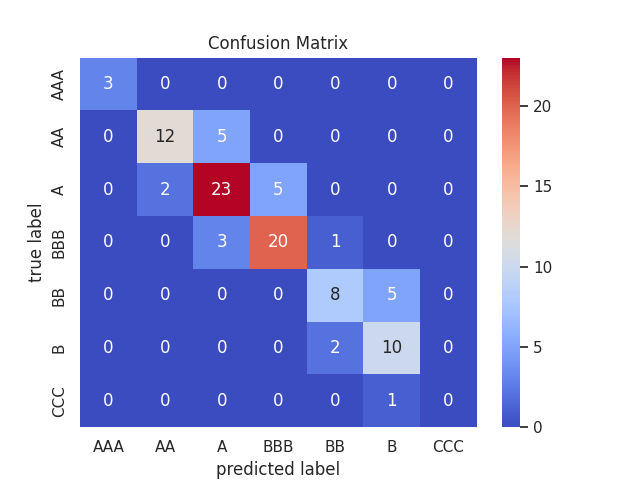

In [17]:
from IPython.display import display, Image
display(Image(filename='confusion_matrix.png'))

#### Code cell 19

Before we deploy an endpoint for our model, we set a variable with the training job name.

In [18]:
training_job_name = estimator.latest_training_job.name
print("Training job name: ", training_job_name)

Training job name:  sagemaker-soln-ccr-js-training-2025-08-23-10-55-58-554


#### Code cell 20

To deploy our model to an endpoint, we first attach the model artifacts produced from the previous code cell.

In [19]:
from sagemaker.mxnet import MXNet
attached_estimator = MXNet.attach(training_job_name)
attached_estimator.model_data


2025-08-23 11:12:51 Starting - Preparing the instances for training
2025-08-23 11:12:51 Downloading - Downloading the training image
2025-08-23 11:12:51 Training - Training image download completed. Training in progress.
2025-08-23 11:12:51 Uploading - Uploading generated training model
2025-08-23 11:12:51 Completed - Training job completed


's3://sagemaker-lab-bucket-876113002723-53757e90/output/sagemaker-soln-ccr-js-training-2025-08-23-10-55-58-554/output/model.tar.gz'

#### Code cell 21

In this cell, we deploy the model artifact (from the previous code cell) to an endpoint that we can use for inference. We use the [SageMaker MXNet model](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html#mxnet-model) and [SageMaker model deployment](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/using_mxnet.html#deploy-mxnet-models) APIs to deploy an endpoint. If you bring your own data for inference, you might also need to update the inference script `inference.py` in the `model-inference` folder.

In [20]:
from sagemaker.mxnet import MXNetModel

endpoint_name = SOLUTION_PREFIX + "-endpoint"

deployed_model = MXNetModel(
    framework_version="1.8.0", 
    py_version="py37", 
    model_data=attached_estimator.model_data, 
    role=ROLE,
    entry_point="inference.py", 
    code_location='s3://{}'.format(BUCKET),
    source_dir="../model-inference",
    name=SOLUTION_PREFIX + "-model",
    enable_network_isolation=True)     # Set enable_network_isolation=True to ensure a security running environment

ccr_endpoint = deployed_model.deploy(
    instance_type='ml.m5.xlarge',  
    initial_instance_count=1,
    endpoint_name=endpoint_name,
    wait=True)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-lab-bucket-876113002723-53757e90/output/sagemaker-soln-ccr-js-training-2025-08-23-10-55-58-554/output/model.tar.gz), script artifact (../model-inference), and dependencies ([]) into single tar.gz file located at s3://sagemaker-lab-bucket-876113002723-53757e90/sagemaker-cq-lab-model/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-cq-lab-model
INFO:sagemaker:Creating endpoint-config with name sagemaker-cq-lab-endpoint
INFO:sagemaker:Creating endpoint with name sagemaker-cq-lab-endpoint


--------!

#### Code cell 22

To test the endpoint, we need data to feed to it. For this solution, we use some of the test dataset that we previously seperated.

In [21]:
test_endpoint_data = test_data.sample(n=5).drop(["Rating"], axis=1)
test_endpoint_data

,MDNA,industry_code,A,B,C,D,E,positive,negative,certainty,uncertainty,risk,safe,litigious,fraud,sentiment,polarity,readability
19,MANAGEMENT’S DISCUSSION AND ANALYSIS OF RESUL...,B,0.014547,0.160812,3.221839,0.045136,0.248177,0.079932,0.031888,0.029167,0.020323,0.058673,0.053401,0.025085,0.023299,0.058,0.429658,13.23
293,Management's Discussion and Analysis of Finan...,D,0.012546,0.134166,2.516621,0.137639,0.243970,0.084019,0.042009,0.025813,0.036315,0.043022,0.043907,0.032013,0.021005,0.070,0.333333,13.58
364,MANAGEMENT'S DISCUSSIONAND ANALYSIS OF FINAN...,B,0.011582,0.121438,3.503971,0.082315,0.284047,0.083397,0.029104,0.038210,0.029870,0.043656,0.044166,0.024594,0.030721,0.082,0.482602,12.95
252,— MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINA...,G,0.012329,0.149047,3.615648,0.105622,0.251412,0.069384,0.029662,0.019705,0.024995,0.035366,0.053412,0.035159,0.019187,0.095,0.401047,13.58
340,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FIN...,D,0.012463,0.136313,2.929040,0.040362,0.249782,0.082378,0.042891,0.030629,0.027626,0.060457,0.050598,0.038487,0.033532,0.063,0.315222,12.77


#### Code cell 23

Now, we call the endpoint and provide the test data. This test shows that the endpoint is running and ready to receive real-time inference requests.

In [22]:
import sagemaker
from sagemaker import Predictor

endpoint_name = SOLUTION_PREFIX + "-endpoint" 


predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker.Session(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
    serializer=sagemaker.serializers.CSVSerializer(),
)

predictor.predict(test_endpoint_data.values)

['BBB', 'B', 'A', 'BBB', 'B']

### End of this notebook

You can return to the solution practice lab steps within the game, but don't close this window yet!